# Simulating the SSH model

Here we simulate the SSH model using the Pulser backend.
We follow the work of De Léséleuc et al. in ["Observation of a symmetry-protected topological phase of interacting bosons with Rydberg atoms"](https://www.science.org/doi/10.1126/science.aav9105) (available also on [arxiv](https://arxiv.org/abs/1810.13286)).

Using a Microwave channel, the interaction Hamiltonian is given by
$$ H = \sum_{i=1}^N \sum_{j<i} C_{ij} (\sigma_i^+ \sigma_j^- + \sigma_i^- \sigma_j^+) $$

where 
$$ C_{ij} = \frac{C_3(1-3\cos^2\theta_{ij})}{R_{ij}^3} .$$
Here $R_{ij}$ is the distance between qubits $i$ and $j$, $R_{ij}=|\textbf{x}_i-\textbf{x}_j|$, and $\theta_{ij}$ is the angle between $\textbf{x}_i-\textbf{x}_j$ and the magnetic field.
See the [Pulser docs](https://pulser.readthedocs.io/en/stable/tutorials/xy_spin_chain.html) for more information.

By appropriate choice of the qubit geometry we can approximate the [SSH model](https://en.wikipedia.org/wiki/Su%E2%80%93Schrieffer%E2%80%93Heeger_model) for hard bosons.
For example, when 
$$ \theta_{ij} = \cos^{-1}\sqrt{1/3}$$
there will be no interaction between qubits $i$ and $j$. We use this to model the SSH model below.


In [1]:
import qse
import pulser
import numpy as np
import matplotlib.pyplot as plt

In [2]:
angle = np.arccos(np.sqrt(1.0 / 3.0)) * 180 / np.pi
print(angle)

54.735610317245346


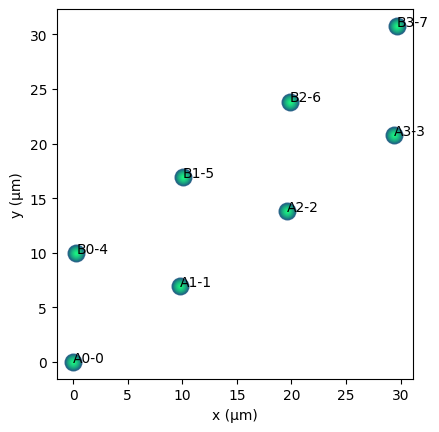

In [3]:
lattice_spacing = 12
repeats = 4

qbits1 = qse.lattices.chain(lattice_spacing=lattice_spacing, repeats=repeats)
qbits1.labels = [f"A{i}" for i in range(repeats)]

qbits2 = qse.lattices.chain(lattice_spacing=lattice_spacing, repeats=repeats)
qbits2.labels = [f"B{i}" for i in range(repeats)]
qbits2.translate((lattice_spacing * 0.5, 8, 0))

qbits_ssh = qbits1 + qbits2
qbits_ssh.rotate(90 - angle)  # by rotating to this angle interactions will cancel.

for i in range(qbits_ssh.nqbits):
    qbits_ssh.labels[i] += f"-{i}"

qbits_ssh.draw(show_labels=True, units="µm")

In [4]:
# Let's check the Hamiltonian values
magnetic_field = np.array([0.0, 1.0, 0.0])
c3 = 3700


def compute_hamilton_coef(i, j):
    r = qbits_ssh.positions[i] - qbits_ssh.positions[j]
    d = np.linalg.norm(r)
    r /= d
    cos_theta = np.dot(r, magnetic_field)
    return c3 * (1 - 3 * cos_theta**2) / d**3


couplings = [
    [compute_hamilton_coef(i, j) for j in range(i + 1, qbits_ssh.nqbits)]
    for i in range(qbits_ssh.nqbits - 1)
]
couplings = [j for i in couplings for j in i]
coupling_mat = np.zeros((qbits_ssh.nqbits, qbits_ssh.nqbits))
coupling_mat[np.triu_indices(qbits_ssh.nqbits, 1)] = couplings
couplings
for i in range(1, qbits_ssh.nqbits):
    print(f"Coupling between qbits 0 & {i}:", coupling_mat[0, i])

Coupling between qbits 0 & 1: -4.754427304529029e-16
Coupling between qbits 0 & 2: -5.943034130661286e-17
Coupling between qbits 0 & 3: 0.0
Coupling between qbits 0 & 4: -7.391286573549234
Coupling between qbits 0 & 5: -0.5880494737584242
Coupling between qbits 0 & 6: -0.09525640675644509
Coupling between qbits 0 & 7: -0.026269374219942052


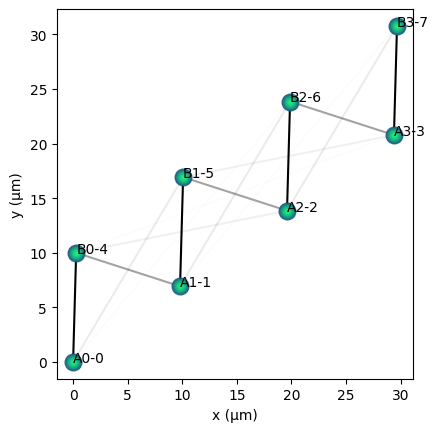

In [8]:
# Let's visualize the couplings
bonds = np.abs(coupling_mat)
bonds /= np.max(bonds)
qbits_ssh.draw(show_labels=True, units="µm")
for i in range(0, qbits_ssh.nqbits - 1):
    for j in range(i + 1, qbits_ssh.nqbits):
        xs_ij = qbits_ssh.positions[[i, j]]
        plt.plot(xs_ij[:, 0], xs_ij[:, 1], c="k", alpha=bonds[i, j], zorder=-1)

In [6]:
simple_pulse = pulser.Pulse.ConstantPulse(10, 0.0, 0.0, 0.0)
pcalc_ssh = qse.calc.Pulser(
    qbits=qbits_ssh,
    amplitude=simple_pulse.amplitude,
    detuning=simple_pulse.detuning,
    channel="mw_global",
    magnetic_field=magnetic_field,
)
pcalc_ssh.build_sequence()
pcalc_ssh.calculate()

10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.0%. Run time:   0.00s. Est. time left: 00:00:00:00
30.0%. Run time:   0.00s. Est. time left: 00:00:00:00
40.0%. Run time:   0.00s. Est. time left: 00:00:00:00
50.0%. Run time:   0.00s. Est. time left: 00:00:00:00
60.0%. Run time:   0.00s. Est. time left: 00:00:00:00
70.0%. Run time:   0.00s. Est. time left: 00:00:00:00
80.0%. Run time:   0.00s. Est. time left: 00:00:00:00
90.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
time in compute and simulation = 0.0343019962310791 s.


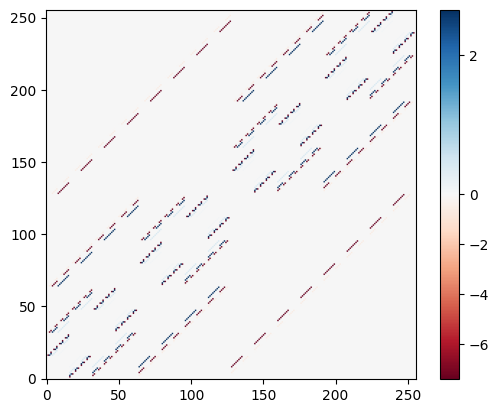

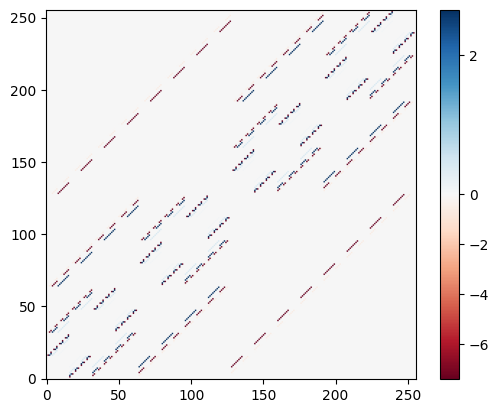

In [7]:
ham = pcalc_ssh.sim.get_hamiltonian(0).full()
qse.visualise.view_matrix(ham.real)

In [ ]:
lattice_spacing = 12
repeats = 4

qbits1 = qse.lattices.chain(lattice_spacing=lattice_spacing, repeats=repeats)
qbits1.labels = [f"A{i}" for i in range(repeats)]

qbits2 = qse.lattices.chain(lattice_spacing=lattice_spacing, repeats=repeats)
qbits2.labels = [f"B{i}" for i in range(repeats)]
qbits2.translate((lattice_spacing * 0.5, 8, 0))

qbits_trivial = qbits1 + qbits2
qbits_trivial.rotate(90 - 54.7)

qbits_trivial.draw(show_labels=True, units="µm")

In [ ]:
lattice_spacing = 12
repeats = 4

qbits1 = qse.lattices.chain(lattice_spacing=lattice_spacing, repeats=repeats)
qbits1.labels = [f"A{i}" for i in range(repeats)]

qbits2 = qse.lattices.chain(lattice_spacing=lattice_spacing, repeats=repeats)
qbits2.labels = [f"B{i}" for i in range(repeats)]
qbits2.translate((-lattice_spacing * 0.5, 8, 0))

qbits_topological = qbits1 + qbits2
qbits_topological.rotate(90 - 54.7)

qbits_topological.draw(show_labels=True, units="µm")

In [ ]:
t_rise = 1200  # ns
t_sweep = 1200  # ns
t_fall = 1200  # ns

# up ramp, constant, downramp waveform
omega_max = 1.8 * 2 * np.pi  # rad/µs

amplitude_afm = pulser.CompositeWaveform(
    pulser.waveforms.RampWaveform(t_rise, 0.0, omega_max),
    pulser.waveforms.ConstantWaveform(t_sweep, omega_max),
    pulser.waveforms.RampWaveform(t_fall, omega_max, 0.0),
)


delta_0 = -4.5 * 2 * np.pi  # rad/µs
delta_f = 3.5 * 2 * np.pi  # rad/µs

# corresponding waveform for detuning
detuning_afm = pulser.CompositeWaveform(
    pulser.waveforms.ConstantWaveform(t_rise, delta_0),
    pulser.waveforms.RampWaveform(t_sweep, delta_0, delta_f),
    pulser.waveforms.ConstantWaveform(t_fall, delta_f),
)

In [ ]:
pulser.Pulse(amplitude=amplitude_afm, detuning=detuning_afm, phase=0.0).draw()

In [ ]:
pcalc_trivial = qse.calc.Pulser(
    qbits=qbits_trivial,
    amplitude=amplitude_afm,
    detuning=detuning_afm,
    channel="mw_global",
    magnetic_field=np.array(
        [0.0, 1.0, 0.0],
    ),
)
pcalc_trivial.build_sequence()
pcalc_trivial.calculate()

pcalc_topological = qse.calc.Pulser(
    qbits=qbits_topological,
    amplitude=amplitude_afm,
    detuning=detuning_afm,
    channel="mw_global",
    magnetic_field=np.array(
        [0.0, 1.0, 0.0],
    ),
)
pcalc_topological.build_sequence()
pcalc_topological.calculate()

In [ ]:
pcalc_topological.sim.get_hamiltonian(0)

In [ ]:
occupations_trivial = qse.magnetic.get_number_operator(
    statevector=pcalc_trivial.statevector, nqbits=qbits_trivial.nqbits
)

occupations_topological = qse.magnetic.get_number_operator(
    statevector=pcalc_topological.statevector, nqbits=qbits_topological.nqbits
)

In [ ]:
xs = np.arange(qbits_trivial.nqbits)
width = 0.4

plt.bar(xs - width * 0.5, occupations_trivial, width=width, label="trivial")
plt.bar(xs + width * 0.5, occupations_topological, width=width, label="topological")

plt.legend()
plt.xticks(xs, qbits_trivial.labels)
plt.xlabel("Qbit")
plt.ylabel("Occupation")
plt.show()